In [1]:
import xarray as xr
from pathlib import Path
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from xhistogram.xarray import histogram
import calendar
# Dynamically determine the project root directory
project_root = Path(os.getcwd()).parent
sys.path.insert(0, str(project_root))
from src.data_loading.simple_loader import load_processed_berkeley_earth, load_processed_era5, load_config, load_elevation_data, load_station_density_data



In [3]:
be = load_processed_berkeley_earth('tavg')
era5 = load_processed_era5('tavg')
elevation = load_elevation_data()
station_data = load_station_density_data()

In [ ]:
# calculate average elevation for each quarter degree grid cell in the Berkeley Earth data
coarsen_factor = 6
elevation_coarse = elevation.coarsen(latitude=coarsen_factor, longitude=coarsen_factor, boundary='trim').mean()
elevation_coarse_interp = elevation_coarse.interp_like(be)

In [96]:
elevation_coarse_interp

<xarray.Dataset> Size: 8MB
Dimensions:    (latitude: 720, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
Data variables:
    elevation  (latitude, longitude) float64 8MB 2.775e+03 2.775e+03 ... 0.0 0.0

In [ ]:
# calculate number of stations in each quarter deggree grid cell for each month
time_start = np.datetime64('2024-12-01')
time_end = np.datetime64('2024-12-31')
test = station_data.sel(time=slice(time_start,time_end))
stations = test.where(test.occurrence_table==1).dropna('location', how='all').dropna('time', how='all')
# Count stations in each Berkeley Earth grid cell
station_counts = histogram(
    stations.latitude, 
    stations.longitude,
    bins=[be.latitude.values, be.longitude.values],
    dim=['location']  # specify the dimension to histogram over
)


In [88]:
# Initialize empty array to store all station counts
# Use the actual histogram output shape, not the coordinate lengths
station_counts_array = np.zeros((len(be.time), len(be.latitude)-1, len(be.longitude)-1))

for i, time_val in enumerate(be.time):
    year = time_val.dt.year.item()
    month = time_val.dt.month.item()
    time_start = np.datetime64(f'{year}-{month:02d}-01')
    last_day = calendar.monthrange(year, month)[1]
    time_end = np.datetime64(f'{year}-{month:02d}-{last_day:02d}')
    
    time_slice = station_data.sel(time=slice(time_start, time_end))
    stations = time_slice.where(time_slice.occurrence_table==1).dropna('location', how='all').dropna('time', how='all')
    
    station_counts = histogram(
        stations.latitude, 
        stations.longitude,
        bins=[be.latitude.values, be.longitude.values],
        dim=['location']
    )
    
    # Store the 2D array in the 3D array
    station_counts_array[i, :, :] = station_counts.values

# Create the final dataset using the histogram's coordinates
all_stations = xr.Dataset({
    'station_counts': (['time', 'latitude_bin', 'longitude_bin'], station_counts_array)
}, coords={
    'latitude_bin': station_counts.latitude_bin,  # Use the bin coordinates from histogram
    'longitude_bin': station_counts.longitude_bin,
    'time': be.time
})

print(f"Final dataset shape: {all_stations.station_counts.shape}")
print(all_stations)


Final dataset shape: (2104, 719, 1439)
<xarray.Dataset> Size: 17GB
Dimensions:         (time: 2104, latitude_bin: 719, longitude_bin: 1439)
Coordinates:
  * latitude_bin    (latitude_bin) float32 3kB -89.75 -89.5 ... 89.5 89.75
  * longitude_bin   (longitude_bin) float32 6kB -179.8 -179.5 ... 179.5 179.8
  * time            (time) datetime64[ns] 17kB 1850-01-16 ... 2025-04-17
Data variables:
    station_counts  (time, latitude_bin, longitude_bin) float64 17GB 0.0 ... 0.0


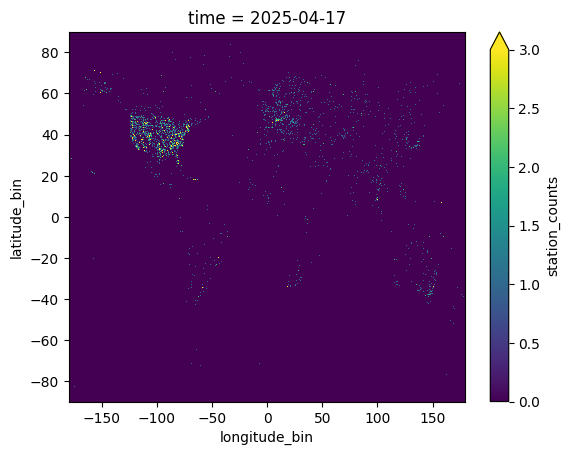

In [95]:
all_stations.station_counts[-1].plot(vmin = 0, vmax=3)

<xarray.DataArray 'histogram_latitude_longitude' (time: 2104,
                                                  latitude_bin: 719,
                                                  longitude_bin: 1439)> Size: 17GB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(2104, 719, 1439))
Coordinates:
  * time           (time) datetime64[ns] 17kB 1850-01-16 ... 2025-04-17
  * latitude_bin   (latitude_bin) float32 3kB -89.75 -89.5 -89.25 ... 89.5 89.75
  * longitude_bin  (longitude_bin) float32 6kB -179.8 -179.5 ... 179.5 179.8

In [74]:
station_counts

<xarray.DataArray 'histogram_latitude_longitude' (time: 1, latitude_bin: 719,
                                                  longitude_bin: 1439)> Size: 8MB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(1, 719, 1439))
Coordinates:
  * time           (time) datetime64[ns] 8B 2025-04-17
  * latitude_bin   (latitude_bin) float32 3kB -89.75 -89.5 -89.25 ... 89.5 89.75
  * longitude_bin  (longitude_bin) float32 6kB -179.8 -179.5 ... 179.5 179.8

In [ ]:
import calendar

# Initialize list to store results for each time
all_station_counts = []

for time_val in be.time:
    year = time_val.dt.year.item()
    month = time_val.dt.month.item()
    time_start = np.datetime64(f'{year}-{month:02d}-01')
    last_day = calendar.monthrange(year, month)[1]
    time_end = np.datetime64(f'{year}-{month:02d}-{last_day:02d}')
    
    test = station_data.sel(time=slice(time_start, time_end))
    stations = test.where(test.occurrence_table==1).dropna('location', how='all').dropna('time', how='all')
    
    station_counts = histogram(
        stations.latitude,
        stations.longitude,
        bins=[be.latitude.values, be.longitude.values],
        dim=['location']
    )
    
    # Add time coordinate to this month's data
    station_counts = station_counts.expand_dims('time')
    station_counts = station_counts.assign_coords(time=[time_val.values])
    
    all_station_counts.append(station_counts)

# Concatenate all months into one dataset
station_counts_dataset = xr.concat(all_station_counts, dim='time')

# Rename dimensions to match your desired structure
station_counts_dataset = station_counts_dataset.rename({
    'latitude_bin': 'latitude',
    'longitude_bin': 'longitude'
})

# Create final dataset with proper coordinates
final_dataset = xr.Dataset({
    'station_counts': station_counts_dataset
}, coords={
    'latitude': be.latitude.values,
    'longitude': be.longitude.values, 
    'time': be.time.values
})

print(f"Final dataset shape: {final_dataset.station_counts.shape}")
print(final_dataset)

In [ ]:
import calendar

# Initialize list to store results for each time
all_station_counts = []

for time_val in be.time:
    year = time_val.dt.year.item()
    month = time_val.dt.month.item()
    time_start = np.datetime64(f'{year}-{month:02d}-01')
    last_day = calendar.monthrange(year, month)[1]
    time_end = np.datetime64(f'{year}-{month:02d}-{last_day:02d}')
    
    test = station_data.sel(time=slice(time_start, time_end))
    stations = test.where(test.occurrence_table==1).dropna('location', how='all').dropna('time', how='all')
    
    station_counts = histogram(
        stations.latitude,
        stations.longitude,
        bins=[be.latitude.values, be.longitude.values],
        dim=['location']
    )
    
    # Add time coordinate to this month's data
    station_counts = station_counts.expand_dims('time')
    station_counts = station_counts.assign_coords(time=[time_val.values])
    
    all_station_counts.append(station_counts)

# Concatenate all months into one dataset
station_counts_dataset = xr.concat(all_station_counts, dim='time')

# Rename dimensions to match your desired structure
station_counts_dataset = station_counts_dataset.rename({
    'latitude_bin': 'latitude',
    'longitude_bin': 'longitude'
})

# Create final dataset with proper coordinates
final_dataset = xr.Dataset({
    'station_counts': station_counts_dataset
}, coords={
    'latitude': be.latitude.values,
    'longitude': be.longitude.values, 
    'time': be.time.values
})

print(f"Final dataset shape: {final_dataset.station_counts.shape}")
print(final_dataset)

In [58]:

# Count stations in each Berkeley Earth grid cell
station_counts = histogram(
    stations.latitude, 
    stations.longitude,
    bins=[be.latitude.values, be.longitude.values],
    dim=['location']  # specify the dimension to histogram over
)

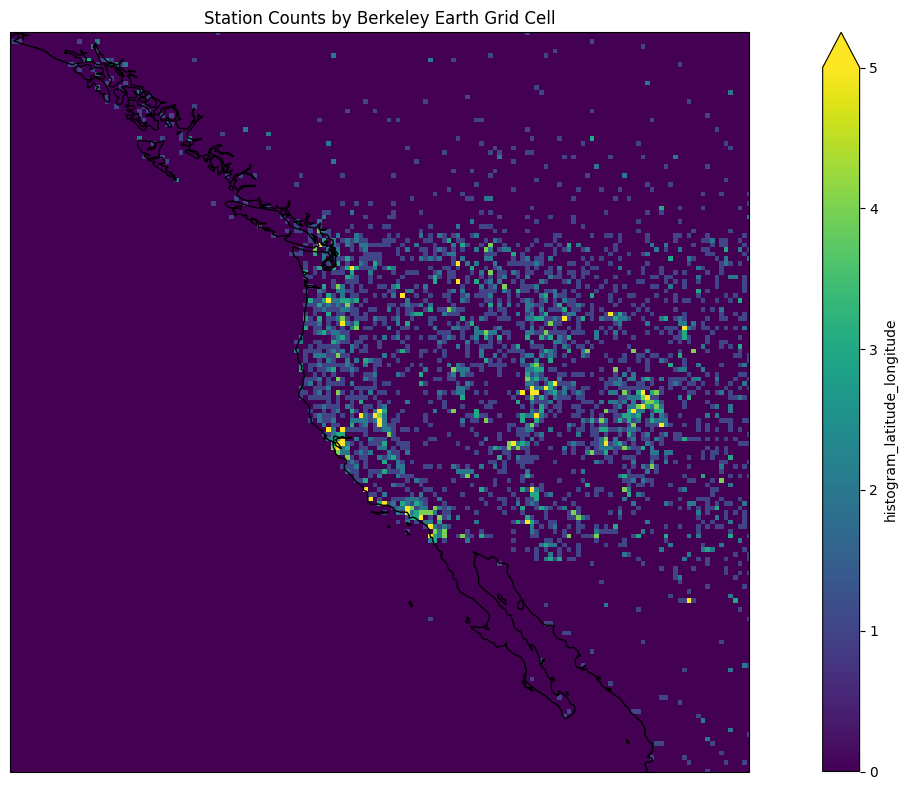

In [64]:
# Create figure with map projection
fig = plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the station counts
im = station_counts.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    vmin = 0,
    vmax = 5
)
ax.coastlines()
# Set extent to western North America
ax.set_extent([-140, -100, 20, 60], crs=ccrs.PlateCarree())

plt.title('Station Counts by Berkeley Earth Grid Cell')
plt.tight_layout()
plt.show()

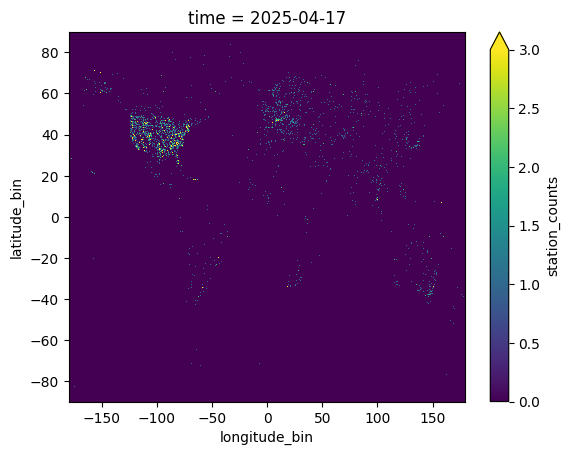

In [8]:
config = load_config()
test = xr.open_dataset(config['station_density_processed'])
test.station_counts[-1].plot(vmin = 0, vmax = 3)

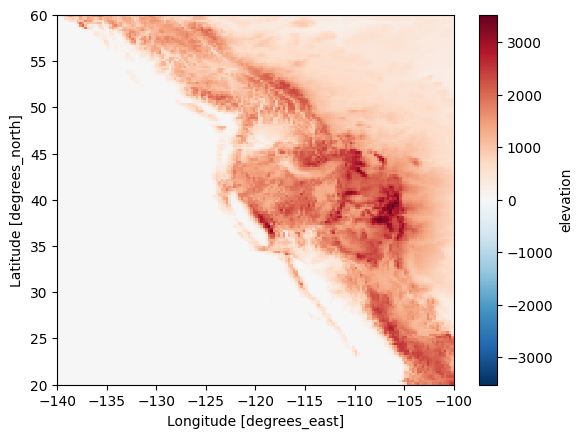

In [65]:
# plot only westurn united states elevation
elevation_coarse_interp.elevation.sel(latitude=slice(20, 60), longitude=slice(-140, -100)).plot()

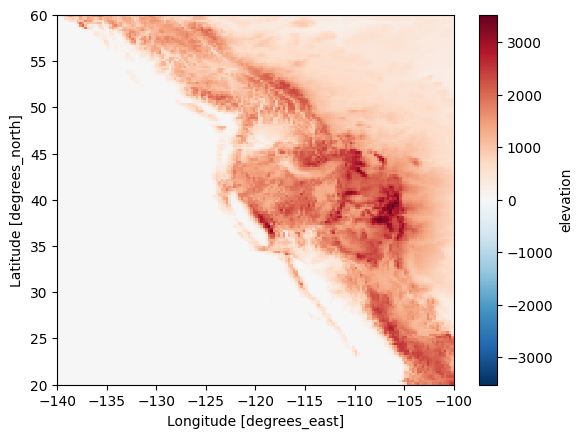

In [2]:
config = load_config()
test = xr.open_dataset(config['elevation_processed'])
test.elevation.sel(latitude=slice(20, 60), longitude=slice(-140, -100)).plot()